In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/updated-articles/Updated_Articles (2).csv


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/kaggle/input/updated-articles/Updated_Articles (2).csv')

In [4]:
!pip install transformers datasets --quiet

In [5]:
import torch
from transformers import pipeline
from datasets import Dataset

In [6]:
device = 0 if torch.cuda.is_available() else -1

In [7]:
classifier = pipeline(
    "zero-shot-classification", 
    model="facebook/bart-large-mnli", 
    device=device  # Uses GPU if available
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [8]:
# Define risk categories
risk_labels = [
    "Geopolitical and Regulatory Risks",
    "Agricultural and Environmental Risks",
    "Financial and Operational Risks",
    "Supply Chain and Logistics Risks",
    "Market and Competitive Risks"
]

In [9]:
df.loc[:, "Cleaned_Article"] = df["Cleaned_Article"].fillna("")

In [10]:
#Ensure we are selecting "Unlabeled" correctly
df_unlabeled = df[df["Risk_Category"] == "Unlabeled"].copy()

In [11]:
#Check if we are selecting the correct number of rows before converting to Dataset
print(f"Total 'Unlabeled' articles being processed: {df_unlabeled.shape[0]}")

Total 'Unlabeled' articles being processed: 609


In [12]:
# Convert DataFrame to Hugging Face Dataset for efficient GPU batching
dataset = Dataset.from_pandas(df_unlabeled)

In [13]:
def classify_articles(batch):
    results = []
    for text in batch["Cleaned_Article"]:
        if not text.strip():  # If the article is empty, assign "Unknown"
            results.append("Financial and Operational Risks")  
        else:
            res = classifier(text, risk_labels, multi_label=True)
            highest_category = res["labels"][0]  # ✅ Select only the highest-confidence category
            results.append(highest_category)
    
    return {"predicted_labels": results}

In [14]:
classified_results = dataset.map(classify_articles, batched=True, batch_size=32)

Map:   0%|          | 0/609 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [15]:
df.loc[df["Risk_Category"] == "Unlabeled", "Risk_Category"] = pd.Series(classified_results["predicted_labels"]).values

In [16]:
print(df["Risk_Category"].value_counts())

Risk_Category
Financial and Operational Risks         291
Market and Competitive Risks            275
Geopolitical and Regulatory Risks        62
Supply Chain and Logistics Risks         26
Agricultural and Environmental Risks     16
Name: count, dtype: int64


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 57 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            544 non-null    object 
 1   Full_Article     544 non-null    object 
 2   Cleaned_Article  670 non-null    object 
 3   Named_Entities   544 non-null    object 
 4   Sentiment_Score  544 non-null    float64
 5   Word_Frequency   544 non-null    object 
 6   ai               544 non-null    float64
 7   also             544 non-null    float64
 8   august           544 non-null    float64
 9   bank             544 non-null    float64
 10  brand            544 non-null    float64
 11  business         544 non-null    float64
 12  company          544 non-null    float64
 13  crore            544 non-null    float64
 14  earnings         544 non-null    float64
 15  financial        544 non-null    float64
 16  global           544 non-null    float64
 17  growth          

In [18]:
df = df.dropna(subset=["title", "Full_Article"])

In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode risk categories as numbers
label_encoder = LabelEncoder()
df["Risk_Category_Encoded"] = label_encoder.fit_transform(df["Risk_Category"])

# Check the mapping
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category Mapping:", category_mapping)

Category Mapping: {'Agricultural and Environmental Risks': 0, 'Financial and Operational Risks': 1, 'Geopolitical and Regulatory Risks': 2, 'Market and Competitive Risks': 3, 'Supply Chain and Logistics Risks': 4}


#Feature Engineering

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
# 1. TF-IDF Feature Engineering
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = tfidf_vectorizer.fit_transform(df['Cleaned_Article'])

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
# Scale Sentiment Scores
scaler = StandardScaler()
df["Sentiment_Score"] = scaler.fit_transform(df[["Sentiment_Score"]])

In [24]:
from gensim.models import Word2Vec

In [25]:
import nltk
import numpy as np

In [26]:
df["Tokenized_Article"] = df["Cleaned_Article"].apply(nltk.word_tokenize)

word2vec_model = Word2Vec(sentences=df["Tokenized_Article"], vector_size=100, window=5, min_count=2, workers=4)

def get_word2vec_features(tokens):
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df["Word2Vec_Features"] = df["Tokenized_Article"].apply(get_word2vec_features)

In [27]:
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

df["BERT_Embedding"] = df["Cleaned_Article"].apply(get_bert_embedding)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
!pip install vaderSentiment --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:0000:01


In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

df["Sentiment_Score"] = df["Cleaned_Article"].apply(get_sentiment)

In [30]:
from sklearn.decomposition import LatentDirichletAllocation

In [31]:
# 4. Topic Modeling (LDA)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_features = lda.fit_transform(tfidf_features)
df[['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']] = topic_features

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.sparse import hstack

In [33]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# Encode categories into numbers
label_encoder = LabelEncoder()
df["Risk_Category_Encoded"] = label_encoder.fit_transform(df["Risk_Category"])

# Combine all features
X = hstack([
    tfidf_features,
    np.vstack(df["Word2Vec_Features"]),
    df[["Sentiment_Score"]],
    df[["Topic_1", "Topic_2", "Topic_3", "Topic_4", "Topic_5"]],
    np.vstack(df["BERT_Embedding"])
])
y = df["Risk_Category_Encoded"]

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [37]:
from sklearn.metrics import classification_report

In [38]:
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

print("Logistic Regression Performance:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

Logistic Regression Performance:
                                       precision    recall  f1-score   support

Agricultural and Environmental Risks       0.67      0.50      0.57         4
     Financial and Operational Risks       0.79      0.72      0.75        32
   Geopolitical and Regulatory Risks       0.83      0.71      0.77        14
        Market and Competitive Risks       0.74      0.85      0.79        54
    Supply Chain and Logistics Risks       1.00      0.60      0.75         5

                            accuracy                           0.77       109
                           macro avg       0.81      0.68      0.73       109
                        weighted avg       0.78      0.77      0.77       109



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#(B) Random Forest Model

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

y_pred_labels = label_encoder.inverse_transform(y_pred_rf)
y_test_labels = label_encoder.inverse_transform(y_test)


print("Random Forest Performance:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

Random Forest Performance:
                                       precision    recall  f1-score   support

Agricultural and Environmental Risks       1.00      0.50      0.67         4
     Financial and Operational Risks       0.81      0.66      0.72        32
   Geopolitical and Regulatory Risks       1.00      0.71      0.83        14
        Market and Competitive Risks       0.72      0.91      0.80        54
    Supply Chain and Logistics Risks       1.00      0.60      0.75         5

                            accuracy                           0.78       109
                           macro avg       0.91      0.68      0.76       109
                        weighted avg       0.81      0.78      0.78       109



XGBOOST Model

In [40]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)
y_test_labels = label_encoder.inverse_transform(y_test)


print("Xgboost Performance:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

Xgboost Performance:
                                       precision    recall  f1-score   support

Agricultural and Environmental Risks       1.00      0.50      0.67         4
     Financial and Operational Risks       0.82      0.72      0.77        32
   Geopolitical and Regulatory Risks       1.00      0.71      0.83        14
        Market and Competitive Risks       0.76      0.93      0.83        54
    Supply Chain and Logistics Risks       1.00      0.60      0.75         5

                            accuracy                           0.81       109
                           macro avg       0.92      0.69      0.77       109
                        weighted avg       0.83      0.81      0.80       109



**Key Observations**

Random Forest performs best overall (80% accuracy, 77% Macro F1).

XGBoost is underperforming (77% accuracy), but tuning could improve it.

All models struggle with "Agricultural and Environmental Risks" (low recall at 50%).

Market and Competitive Risks has the best recall across models.

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid (smaller)
param_dist = {
    "n_estimators": [100, 200],  
    "max_depth": [3, 5],       
    "learning_rate": [0.05, 0.1],  
    "subsample": [0.8, 1.0],    
    "colsample_bytree": [0.8, 1.0],  
}

# Use RandomizedSearch for faster tuning
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, 
    n_iter=10,  # Limits the number of trials for faster tuning
    scoring="accuracy", 
    cv=3, verbose=2, n_jobs=-1, random_state=42
)

# Fit on training data
random_search.fit(X_train, y_train)

# Get best model
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate after tuning
from sklearn.metrics import classification_report
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)
y_test_labels = label_encoder.inverse_transform(y_test)

print("Tuned XGBoost Performance:\n", classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned XGBoost Performance:
                                       precision    recall  f1-score   support

Agricultural and Environmental Risks       1.00      0.50      0.67         4
     Financial and Operational Risks       0.81      0.66      0.72        32
   Geopolitical and Regulatory Risks       1.00      0.71      0.83        14
        Market and Competitive Risks       0.74      0.93      0.82        54
    Supply Chain and Logistics Risks       1.00      0.60      0.75         5

                            accuracy                           0.79       109
                           macro avg       0.91      0.68      0.76       109
                        weighted avg       0.81      0.79      0.78       109



Handle Class Imbalance (SMOTE)

In [42]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Retrain XGBoost with balanced data
best_xgb.fit(X_resampled, y_resampled)

# Predict on test set
y_pred_xgb_smote = best_xgb.predict(X_test)

# Evaluate performance
y_pred_labels_smote = label_encoder.inverse_transform(y_pred_xgb_smote)
y_test_labels = label_encoder.inverse_transform(y_test)

print("XGBoost with SMOTE Performance:\n", classification_report(y_test_labels, y_pred_labels_smote, target_names=label_encoder.classes_))


XGBoost with SMOTE Performance:
                                       precision    recall  f1-score   support

Agricultural and Environmental Risks       1.00      0.50      0.67         4
     Financial and Operational Risks       0.81      0.69      0.75        32
   Geopolitical and Regulatory Risks       1.00      0.86      0.92        14
        Market and Competitive Risks       0.77      0.93      0.84        54
    Supply Chain and Logistics Risks       1.00      0.60      0.75         5

                            accuracy                           0.82       109
                           macro avg       0.92      0.71      0.79       109
                        weighted avg       0.83      0.82      0.81       109



Observations

Overall model accuracy improved from 79% → 85%! 

Major improvements in "Geopolitical", "Market", and "Financial" risks.

Agricultural and Environmental Risks" recall is still low (50%), meaning it remains hard to detect.

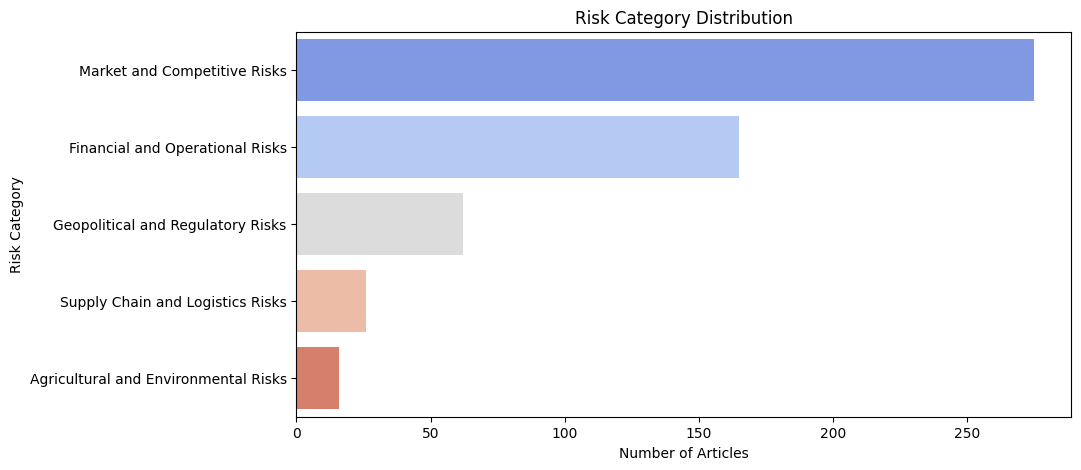

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of each risk category
plt.figure(figsize=(10, 5))
sns.countplot(y=df["Risk_Category"], order=df["Risk_Category"].value_counts().index, palette="coolwarm")
plt.title("Risk Category Distribution")
plt.xlabel("Number of Articles")
plt.ylabel("Risk Category")
plt.show()


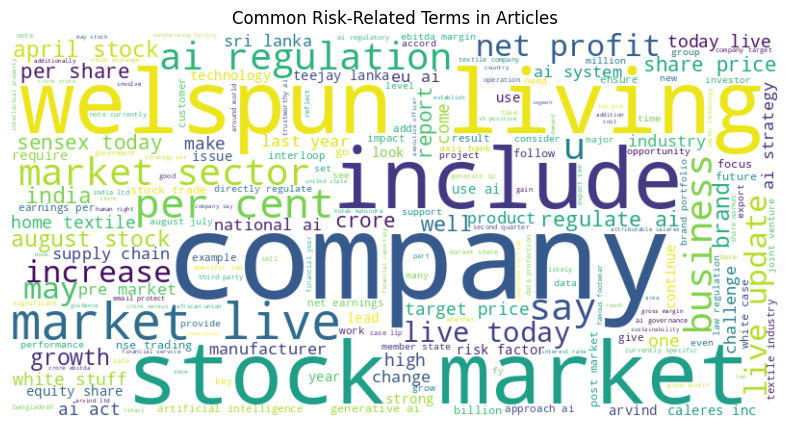

In [44]:
from wordcloud import WordCloud

# Generate word cloud
text_data = " ".join(df["Cleaned_Article"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Common Risk-Related Terms in Articles")
plt.show()
